In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import statsmodels.api as sm

## Data Preparation
This notebook will conduct linear regression on **Tesla** stock

In [2]:
dp_df = pd.read_csv('pt2-dependent.csv').iloc[:, [0, 3, 4]]
ex_df = pd.read_csv('pt2-explainatory.csv').iloc[:, :-2]

In [3]:
new_column_names = ['datetime', 'S&P', 'Gold', 'VIX', 'DX', 'IRX', 'TYX']  

for column in ex_df.columns:
    ex_df = ex_df.rename(columns={column: new_column_names.pop(0)})

df = pd.merge(ex_df, dp_df, on='datetime')
df['datetime'] = pd.to_datetime(df['datetime'])
df.drop('datetime', axis=1, inplace=True)
df.dropna(inplace=True)

## Utilty Functions

In [4]:
# Scaling Data
def scaler_method(df):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_features = scaler.fit_transform(df)
    df_feat = pd.DataFrame(scaled_features, columns=df.columns)
    df_feat["TSLA return"] = df_feat.pop("TSLA return")
    return df_feat

In [219]:
def LinearRegression(X, Y):
      X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

      model = linear_model.LinearRegression()
      model.fit(X_train, Y_train)
      Y_pred = model.predict(X_test)

      print('independent variables:', X.columns.values)
      print('Coefficients:', model.coef_)
      print('Intercept:', model.intercept_)
      print('=========Evaluation=========')
      print('Mean squared error (MSE): %.2f'
            % mean_squared_error(Y_test, Y_pred))
      print('Coefficient of determination (R^2): %.2f'
            % r2_score(Y_test, Y_pred))
      ols_result = sm.OLS(Y_train, X_train).fit()
      print(ols_result.summary())
      
      pred_Y = model.predict(X)
      result = pd.DataFrame({'index': X.index, 'Y': Y.values.flatten(), 'Y_pred': pred_Y.flatten()})

      return model, result

## Base Linear Regression Model

In [6]:
df_feat = df.copy()
for column in df_feat.columns[:-2]:
    df_feat[column + "_log"] = np.log(df_feat[column]).diff()
    df_feat = df_feat.drop(column, axis=1)
df_feat = df_feat.dropna()
df_feat_1 = scaler_method(df_feat)
df_feat_1 = df_feat_1.drop("TSLA price", axis=1)

<Axes: >

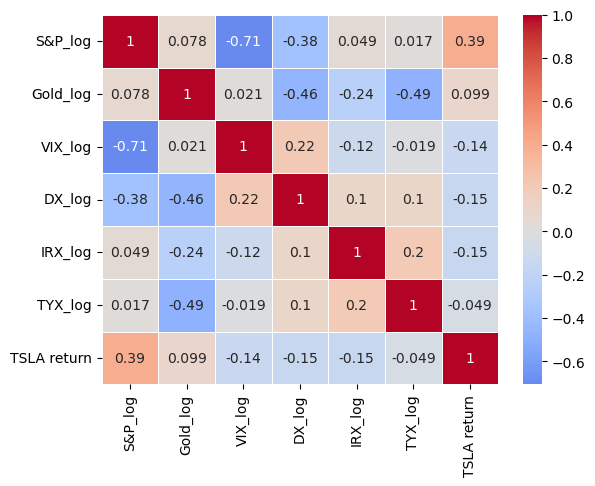

In [7]:
sns.heatmap(df_feat_1.corr(), annot=True, cmap='coolwarm', linewidths=0.5, center=0)

In [8]:
Y = df_feat_1['TSLA return']
X = df_feat_1.drop(['TSLA return'], axis=1)

In [9]:
model, result = LinearRegression(X, Y)

independent variables: ['S&P_log' 'Gold_log' 'VIX_log' 'DX_log' 'IRX_log' 'TYX_log']
Coefficients: [ 0.40253751  0.03467712  0.16437015 -0.11878938 -0.18522553  0.01080791]
Intercept: 0.04618266064635812
=========Evaluation=========
Mean squared error (MSE): 0.14
Coefficient of determination (R^2): 0.06
                                 OLS Regression Results                                
Dep. Variable:            TSLA return   R-squared (uncentered):                   0.230
Model:                            OLS   Adj. R-squared (uncentered):              0.178
Method:                 Least Squares   F-statistic:                              4.427
Date:                Sun, 25 Feb 2024   Prob (F-statistic):                    0.000580
Time:                        14:38:57   Log-Likelihood:                         -15.675
No. Observations:                  95   AIC:                                      43.35
Df Residuals:                      89   BIC:                                   

<Axes: xlabel='index'>

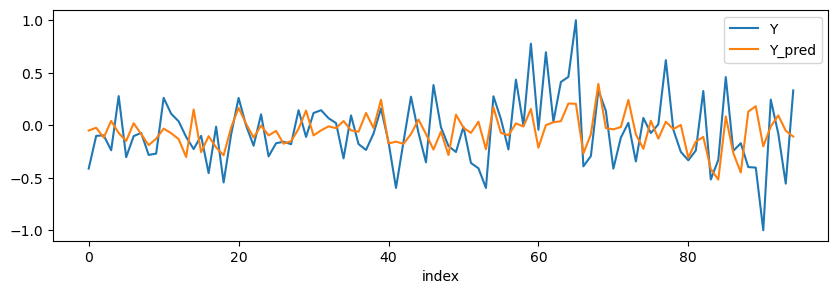

In [10]:
result.plot(x='index', y=['Y', 'Y_pred'], figsize=(10,3))

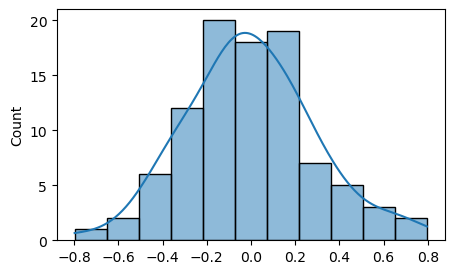

In [11]:
plt.figure(figsize=(5,3))
residual_1 = result['Y'] - result['Y_pred']
sns.histplot(residual_1, kde=True)
plt.show()

## Final Model

In [220]:
new_df = df.copy()

new_df['S&P_log'] = np.log(df['S&P']).diff()

new_df['TYX-IRX'] = np.abs(np.log(df['TYX'] - df['IRX']))

# change VIX to log difference
#new_df['VIX_log'] = np.log(df['VIX']).diff()

new_df.dropna(inplace=True)
new_df.drop("TSLA price", axis=1, inplace=True)
new_df = scaler_method(new_df)

new_df.drop(['IRX', 'Gold', 'TYX', 'DX', 'S&P', 'VIX'], axis=1, inplace=True)
new_df.describe()

/Users/danielbai/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,S&P_log,TYX-IRX,TSLA return
count,89.000000,89.000000,89.000000
mean,-0.101686,-0.568174,-0.314438
std,0.375738,0.261190,0.381701
min,-1.000000,-1.000000,-1.000000
25%,-0.316543,-0.747980,-0.569718
50%,-0.074064,-0.577290,-0.373367
75%,0.125717,-0.437815,-0.122675
max,1.000000,1.000000,1.000000


<Axes: >

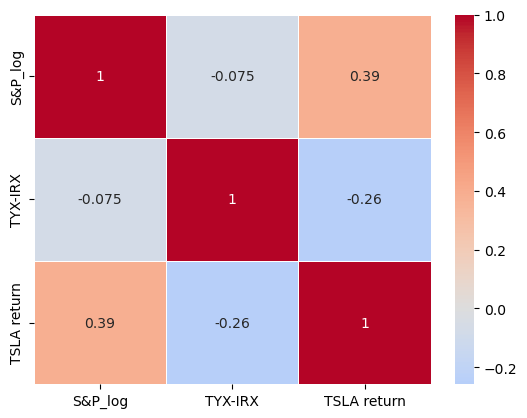

In [221]:
sns.heatmap(new_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5, center=0)

In [222]:
Y = new_df['TSLA return']
X = new_df.drop(['TSLA return'], axis=1)

/Users/danielbai/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


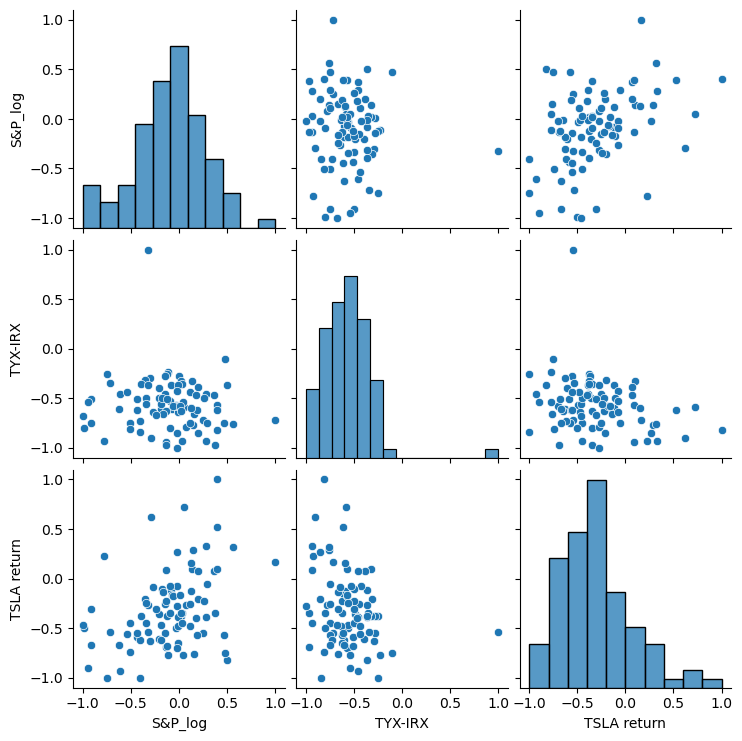

In [223]:
sns.pairplot(new_df)

In [224]:
model, result = LinearRegression(X, Y)

independent variables: ['S&P_log' 'TYX-IRX']
Coefficients: [ 0.32873018 -0.28339501]
Intercept: -0.4354714685988167
=========Evaluation=========
Mean squared error (MSE): 0.08
Coefficient of determination (R^2): 0.40
                                 OLS Regression Results                                
Dep. Variable:            TSLA return   R-squared (uncentered):                   0.328
Model:                            OLS   Adj. R-squared (uncentered):              0.308
Method:                 Least Squares   F-statistic:                              16.83
Date:                Sun, 25 Feb 2024   Prob (F-statistic):                    1.11e-06
Time:                        15:17:22   Log-Likelihood:                         -35.509
No. Observations:                  71   AIC:                                      75.02
Df Residuals:                      69   BIC:                                      79.54
Df Model:                           2                                          

<Axes: xlabel='index'>

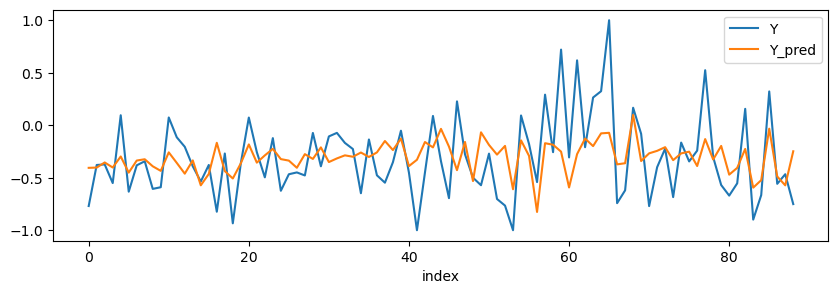

In [217]:
result.plot(x='index', y=['Y', 'Y_pred'], figsize=(10,3))

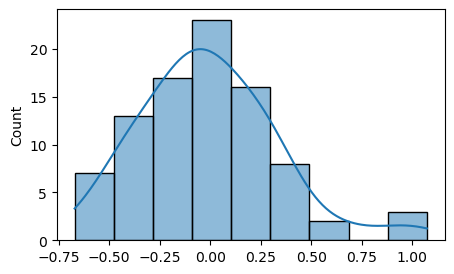

In [218]:
plt.figure(figsize=(5,3))
residual_2 = result['Y'] - result['Y_pred']
sns.histplot(residual_2, kde=True)
plt.show()